## Project 3: Numerical Methods for Differential Equations

## Task 1

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import eigs
from mpl_toolkits.mplot3d import axes3d
from scipy import meshgrid

In [17]:
def toeplitz_like(dim):
    return csr_matrix((diags([1, -2, 1], [-1, 0, 1], shape=(dim, dim))) / (dim + 1)**2)

In [18]:
def add_bounds(y_new, alpha, beta):
    y_new = np.concatenate(([alpha], y_new))
    y_new = np.concatenate((y_new, [beta]))
    return y_new

In [19]:
def euler_step(A: np.array, y_n: np.array, h: float, alpha, beta):
    return add_bounds(y_n + h * A @ y_n, alpha, beta)

## Task 1.1

In [20]:
def euler_solve(g_0_vec, N, M, t_end, alpha, beta):
    xx = np.linspace(0, 1, N+2)
    tt = np.linspace(0, t_end, M+1)
    Y = np.zeros((M+1, N+2))
    Y[0,:] = g_0_vec
    for i in range(M):
        Y[i+1,:] = euler_step(toeplitz_like(N), Y[i,:][1:-1], t_end/M, alpha, beta)
    return Y, tt, xx

In [21]:
def plot3d(Y, t_grid, x_grid):
     T, X = np.meshgrid(np.transpose(t_grid), x_grid)

     fig = plt.figure(figsize=(10, 10))  
     ax = fig.add_subplot(111, projection='3d')
     ax.plot_surface(T, X, np.transpose(Y))

     ax.set_xlabel('Time')
     ax.set_ylabel('Space')

     plt.show()

## Test Task 1.1

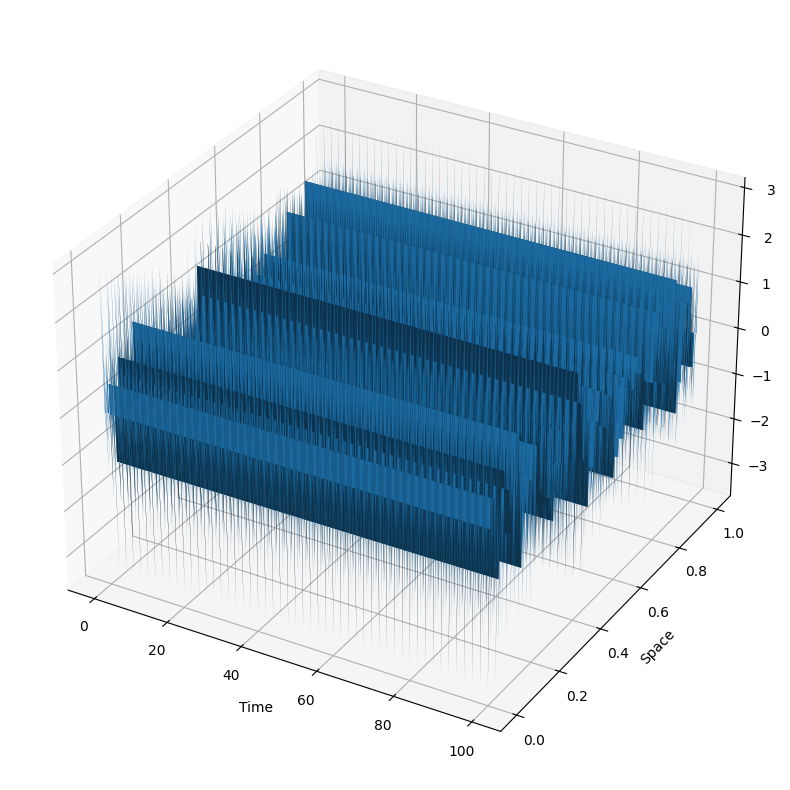

In [23]:
N = 999
M = 999
t_end = 100
alpha = 0
beta = 0

Y, t_grid, x_grid = euler_solve(np.random.normal(loc=0.0, scale=1.0, size=N+2), N, M, t_end, alpha, beta)
plot3d(Y, t_grid, x_grid)